In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from xgboost import XGBClassifier

import warnings
import joblib
import optuna
import shutil
import glob
import json
import gc

warnings.filterwarnings("ignore")

In [3]:
class configs:

    train_path = "playground-series-s5e6/train.csv"
    test_path = "playground-series-s5e6/test.csv"
    original_path = "playground-series-s5e6/Fertilizer Prediction.csv"
    sample_sub_path = "playground-series-s5e6/sample_submission.csv"

    target = "Fertilizer Name"
    n_folds = 5
    seed = 42

## 1. Data Loading

In [4]:
# Load train & test data
train = pd.read_csv(configs.train_path, index_col="id")
test = pd.read_csv(configs.test_path, index_col="id")
original = pd.read_csv(configs.original_path)

cat_cols = train.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != "Fertilizer Name"]
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")
original[cat_cols] = original[cat_cols].astype(str).astype("category")

## 2. Preprocessing

In [5]:
# Encode target "Fertilizer Name"
label_encoder = LabelEncoder()
train[configs.target] = label_encoder.fit_transform(train[configs.target])
original[configs.target] = label_encoder.transform(original[configs.target])

X = train.drop(configs.target, axis=1)
y = train[configs.target]
X_test = test

X_original = original.drop(configs.target, axis=1)
y_original = original[configs.target]

In [6]:
mutual_info = mutual_info_classif(X, y, random_state=configs.seed, discrete_features=True)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Moisture,0.003308
Phosphorous,0.002984
Nitrogen,0.002373
Crop Type,0.002088
Potassium,0.001367
Humidity,0.001015
Temparature,0.000966
Soil Type,0.000617


In [7]:
mutual_info = mutual_info_classif(X_original, y_original, random_state=configs.seed, discrete_features=True)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_original.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Phosphorous,0.001362
Moisture,0.001355
Nitrogen,0.001068
Potassium,0.000626
Humidity,0.000494
Temparature,0.000432
Crop Type,0.000320
Soil Type,0.000107


## 3. Training Models

In [8]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [ ]:
class Trainer:
    def __init__(self, model, config=configs):
        self.model = model
        self.config = config
        self.fitted_model = None  # Will hold the best model

    def fit_predict(self, X, y, X_test, X_original=None, y_original=None, fit_args={}):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        best_score = -np.inf  # For tracking the best fold model
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            if X_original is not None and y_original is not None:
                X_train = pd.concat([X_train, X_original])
                y_train = pd.concat([y_train, y_original])
            
            model = clone(self.model)
            
            if fit_args:
                model.fit(X_train, y_train, **fit_args, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)

            if score > best_score:
                best_score = score
                self.fitted_model = model

            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if fit_args:
                print(f"\n--- Fold {fold_idx + 1} - MAP@3: {score:.6f}\n\n")
            else:
                print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        # Save the best model
        if self.fitted_model is not None:
            model_name = self.fitted_model.__class__.__name__
            filename = f"best_model_{model_name}.json"
            self.fitted_model.save_model(filename)
            print(f"✅ Best model saved to: {filename}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):
        scores = []
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

In [10]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [11]:
lgbm_params = {
    "boosting_type": "gbdt",
    "device": "gpu",
    "colsample_bytree": 0.4366677273946288,
    "learning_rate": 0.016164161953515117,
    "max_depth": 12,
    "min_child_samples": 67,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 243,
    "random_state": 42,
    "reg_alpha": 6.38288560443373,
    "reg_lambda": 9.392999314379155,
    "subsample": 0.7989164499431718,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "device": "gpu",
    "colsample_bytree": 0.32751831793031183,
    "learning_rate": 0.006700715059604966,
    "max_depth": 12,
    "min_child_samples": 84,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 229,
    "random_state": 42,
    "reg_alpha": 6.879977008084246,
    "reg_lambda": 4.739518466581721,
    "subsample": 0.5411572049978781,
    "verbose": -1
}

xgb_params = {
    # https://www.kaggle.com/code/patrykszcz/simple-xgb-model-5-fold
    "device": "gpu",
    "max_depth": 12,
    "colsample_bytree": 0.467,
    "subsample": 0.86,
    "n_estimators": 10000,
    "learning_rate": 0.03,
    "gamma": 0.26,
    "max_delta_step": 4,
    "reg_alpha": 2.7,
    "reg_lambda": 1.4,
    "early_stopping_rounds": 100,
    "objective": 'multi:softprob',
    "random_state": 13,
    "enable_categorical": True,
}

### 3.1. LightGBM_gbdt

In [12]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (gbdt)"], test_pred_probs["LightGBM (gbdt)"], scores["LightGBM (gbdt)"] = lgbm_trainer.fit_predict(X, y, X_test, X_original, y_original, fit_args)

Training LGBMClassifier

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.90089
[2000]	valid_0's multi_logloss: 1.89522
[3000]	valid_0's multi_logloss: 1.89437
[4000]	valid_0's multi_logloss: 1.89435
[5000]	valid_0's multi_logloss: 1.89435
[6000]	valid_0's multi_logloss: 1.89435
Early stopping, best iteration is:
[6189]	valid_0's multi_logloss: 1.89435

--- Fold 1 - MAP@3: 0.361506


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.90035
[2000]	valid_0's multi_logloss: 1.89439
[3000]	valid_0's multi_logloss: 1.89318
Early stopping, best iteration is:
[3125]	valid_0's multi_logloss: 1.89314

--- Fold 2 - MAP@3: 0.362308


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.89963
[2000]	valid_0's multi_logloss: 1.89313
[3000]	valid_0's multi_logloss: 1.89223
[4000]	valid_0's multi_logloss: 1.89223
Early stopping, best iteration is:
[4002]	valid_0's mul

### 3.2. LightGBM_goss

In [13]:
lgb_goss_model = LGBMClassifier(**lgbm_goss_params)
lgb_goss_trainer = Trainer(lgb_goss_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (goss)"], test_pred_probs["LightGBM (goss)"], scores["LightGBM (goss)"] = lgb_goss_trainer.fit_predict(X, y, X_test, X_original, y_original, fit_args)

Training LGBMClassifier

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91088
[2000]	valid_0's multi_logloss: 1.90121
[3000]	valid_0's multi_logloss: 1.89719
[4000]	valid_0's multi_logloss: 1.8957
Early stopping, best iteration is:
[4054]	valid_0's multi_logloss: 1.89567

--- Fold 1 - MAP@3: 0.359724


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91034
[2000]	valid_0's multi_logloss: 1.90043
[3000]	valid_0's multi_logloss: 1.89607
[4000]	valid_0's multi_logloss: 1.89426
Early stopping, best iteration is:
[4430]	valid_0's multi_logloss: 1.89395

--- Fold 2 - MAP@3: 0.360789


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91008
[2000]	valid_0's multi_logloss: 1.89999
[3000]	valid_0's multi_logloss: 1.89546
[4000]	valid_0's multi_logloss: 1.89358
Early stopping, best iteration is:
[4577]	valid_0's multi_logloss: 1.8933

--- Fold 3 - MAP@3: 0

### 3.3. XGBoost

In [14]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)

fit_args = {
    "verbose": 1000
}

oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, X_original, y_original, fit_args)

Training XGBClassifier

[0]	validation_0-mlogloss:1.94557
[1000]	validation_0-mlogloss:1.89239
[1527]	validation_0-mlogloss:1.89140

--- Fold 1 - MAP@3: 0.364848


[0]	validation_0-mlogloss:1.94556
[1000]	validation_0-mlogloss:1.89122
[1654]	validation_0-mlogloss:1.88988

--- Fold 2 - MAP@3: 0.365431


[0]	validation_0-mlogloss:1.94556
[1000]	validation_0-mlogloss:1.89035
[1751]	validation_0-mlogloss:1.88895

--- Fold 3 - MAP@3: 0.367226


[0]	validation_0-mlogloss:1.94558
[1000]	validation_0-mlogloss:1.89241
[1676]	validation_0-mlogloss:1.89119

--- Fold 4 - MAP@3: 0.365647


[0]	validation_0-mlogloss:1.94558
[1000]	validation_0-mlogloss:1.89176
[1641]	validation_0-mlogloss:1.89050

--- Fold 5 - MAP@3: 0.365870



------ Overall MAP@3: 0.365804 | Average MAP@3: 0.365804 ± 0.000788


### 3.4. AutoGluon

In [15]:
oof_preds_files = glob.glob(f'*_oof_pred_probs_*.pkl')
test_preds_files = glob.glob(f'*_test_pred_probs_*.pkl')

ag_oof_preds = joblib.load(oof_preds_files[0])
ag_test_preds = joblib.load(test_preds_files[0])

ag_scores = []
split = StratifiedKFold(n_splits=configs.n_folds, random_state=configs.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]
    score = map3(y_val, y_preds)
    ag_scores.append(score)
    
oof_pred_probs["AutoGluon"], test_pred_probs["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

In [16]:
X2 = pd.DataFrame(np.concatenate(list(oof_pred_probs.values()), axis=1))
X2_test = pd.DataFrame(np.concatenate(list(test_pred_probs.values()), axis=1))

In [17]:
joblib.dump(X2, "oof_pred_probs.pkl")
joblib.dump(X2_test, "test_pred_probs.pkl")

['test_pred_probs.pkl']

In [18]:
lr_model = LogisticRegression(
    random_state=42, 
    max_iter=1000, 
    solver='liblinear', 
    penalty='l2', 
    C=32.89802104596641,
    tol=0.0029878837974181643,
    fit_intercept=True
) 
lr_trainer = Trainer(lr_model)
_, lr_test_pred_probs, scores["LogisticRegression"] = lr_trainer.fit_predict(X2, y, X2_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.364580
--- Fold 2 - MAP@3: 0.365953
--- Fold 3 - MAP@3: 0.367620
--- Fold 4 - MAP@3: 0.366028
--- Fold 5 - MAP@3: 0.365444

------ Overall MAP@3: 0.365925 | Average MAP@3: 0.365925 ± 0.000992


In [19]:
final_predictions = []
for i in np.argsort(lr_test_pred_probs)[:, -3:][:, ::-1]:
    prediction = label_encoder.inverse_transform(i)
    final_predictions.append(" ".join(prediction))

In [20]:
sub = pd.read_csv(configs.sample_sub_path)
sub[configs.target] = final_predictions
sub.to_csv(f"sub_logistic-regression_{np.mean(scores['LogisticRegression']):.6f}.csv", index=False)
sub.head()

,id,Fertilizer Name
0,750000,10-26-26 20-20 DAP
1,750001,17-17-17 20-20 10-26-26
2,750002,20-20 28-28 Urea
3,750003,14-35-14 DAP 17-17-17
4,750004,20-20 Urea 10-26-26


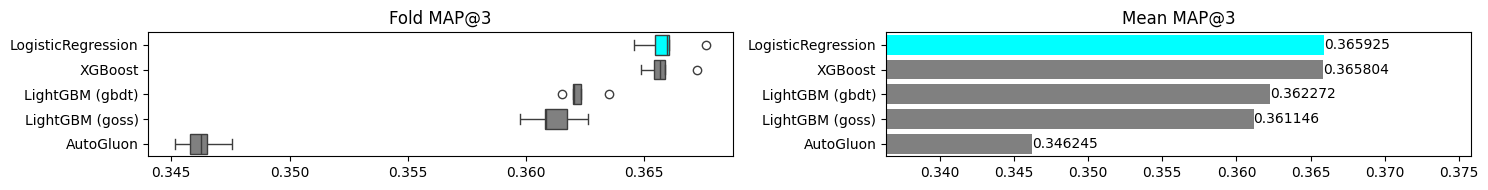

In [21]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "logistic" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()